# Prediction stock price moves with Logistic Regression

## Imports & Settings

In [25]:
from pathlib import Path
import sys, os
from time import time
import warnings
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [26]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [27]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [28]:
YEAR = 252

## Load Data

In [36]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

### Select Investment Universe

In [37]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [38]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Logistic Regression

In [40]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [41]:
target = f'target_{lookahead}d'

In [42]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

1    56443
0    53220
Name: label, dtype: int64

In [43]:
Cs = np.logspace(-5, 5, 11)
log_coeffs, coeffs, log_results, preds = {}, [], [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        preds.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_results.append([C, i, date, auc, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

cols = ['C', 'split', 'date', 'auc', 'ic', 'pval']
log_results = pd.DataFrame(log_results, columns=cols)
log_results.to_hdf('data.h5', 'logistic/metrics')
log_coeffs = pd.DataFrame(log_coeffs, index=X.columns)
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')
pd.concat(preds).to_hdf('data.h5', 'logistic/predictions')

1e-05
	  1.8 | 010 |  -0.22% |  50.38%
	  2.3 | 020 |   2.05% |  51.86%
	  2.8 | 030 |   2.81% |  51.94%
	  3.3 | 040 |   3.24% |  51.92%
	  3.7 | 050 |   3.98% |  52.42%
	  4.1 | 060 |   3.80% |  52.16%
	  4.6 | 070 |   4.68% |  52.54%
0.0001
	  0.5 | 010 |  -0.02% |  50.53%
	  0.9 | 020 |   2.30% |  51.99%
	  1.3 | 030 |   3.18% |  52.18%
	  1.8 | 040 |   3.29% |  52.01%
	  2.2 | 050 |   4.06% |  52.52%
	  2.6 | 060 |   3.94% |  52.26%
	  3.1 | 070 |   4.85% |  52.66%
0.001
	  0.4 | 010 |   0.39% |  50.83%
	  0.9 | 020 |   2.48% |  52.06%
	  1.3 | 030 |   3.60% |  52.42%
	  1.7 | 040 |   3.09% |  51.98%
	  2.2 | 050 |   3.94% |  52.53%
	  2.6 | 060 |   4.05% |  52.33%
	  3.1 | 070 |   4.98% |  52.73%
0.01
	  0.6 | 010 |   0.65% |  50.99%
	  1.2 | 020 |   2.33% |  51.86%
	  1.9 | 030 |   3.62% |  52.31%
	  2.4 | 040 |   3.03% |  51.85%
	  3.0 | 050 |   3.98% |  52.46%
	  3.6 | 060 |   4.11% |  52.26%
	  4.2 | 070 |   4.91% |  52.63%
0.1
	  0.7 | 010 |   0.62% |  50.97%
	  1.4 | 020 | 

In [44]:
log_results = pd.read_hdf('data.h5', 'logistic/metrics')

In [45]:
log_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 6 columns):
C        825 non-null float64
split    825 non-null int64
date     825 non-null datetime64[ns]
auc      825 non-null float64
ic       825 non-null float64
pval     825 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 45.1 KB


In [46]:
log_results.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524091,0.036383,0.435663,0.500763,0.520733,0.543778,0.622890
0.00010,75.0,0.525150,0.035849,0.447279,0.501376,0.521471,0.539950,0.632493
0.00100,75.0,0.525816,0.036395,0.443565,0.504216,0.521435,0.545376,0.643671
0.01000,75.0,0.525028,0.036298,0.441677,0.501655,0.520369,0.548989,0.639373
0.10000,75.0,0.523277,0.035618,0.435530,0.499198,0.520834,0.547408,0.618146
1.00000,75.0,0.522831,0.035534,0.433749,0.497660,0.520901,0.548078,0.613230
10.00000,75.0,0.522789,0.035541,0.433415,0.497721,0.520992,0.548118,0.612596
100.00000,75.0,0.522784,0.035532,0.433420,0.497717,0.520992,0.548099,0.612488
1000.00000,75.0,0.522784,0.035531,0.433391,0.497719,0.520996,0.548089,0.612484


In [47]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2%}\nMedian: {median:5.2%}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300) 

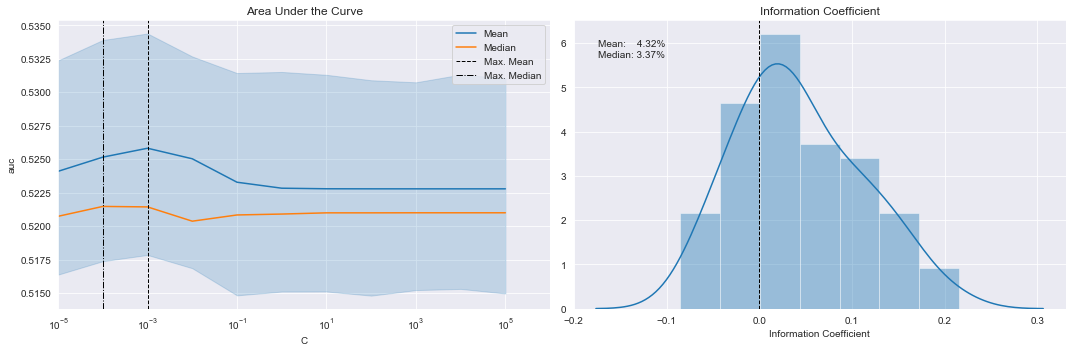

In [49]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_results, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_results.groupby('C').auc.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_results[log_results.C==1e5], ax=axes[1])
axes[1].set_title('Information Coefficient')
fig.tight_layout()
fig.savefig('figures/log_results', dpi=300);